In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.cluster import KMeans
import warnings

# Olası uyarıları bastır
warnings.filterwarnings('ignore')

In [20]:
def match_and_draw(descriptor_name, img1_bgr, img2_bgr):
    """
    İki görüntü arasında özellik tespiti, eşleştirme ve RANSAC ile geometrik doğrulama yapar.
    Sonuçları görselleştirir.
    """
    print(f"\n--- {descriptor_name} ile Eşleştirme Başlatıldı ---")

    # Görüntüleri gri seviyeye çevir
    img1_gray = cv2.cvtColor(img1_bgr, cv2.COLOR_BGR2GRAY)
    img2_gray = cv2.cvtColor(img2_bgr, cv2.COLOR_BGR2GRAY)

    # 1. Özellik çıkarıcıyı oluşturma
    if descriptor_name.upper() == 'SIFT':
        try:
            detector = cv2.SIFT_create()
        except cv2.error:
            print("Hata: SIFT kullanılamıyor. `pip install opencv-contrib-python` ile kurmayı deneyin.")
            return
    elif descriptor_name.upper() == 'ORB':
        detector = cv2.ORB_create(nfeatures=1000)
    else:
        print(f"Bilinmeyen tanımlayıcı: {descriptor_name}")
        return

    # 2. Anahtar noktaları ve tanımlayıcıları bulma
    kp1, des1 = detector.detectAndCompute(img1_gray, None)
    kp2, des2 = detector.detectAndCompute(img2_gray, None)

    if des1 is None or des2 is None or len(des1) < 2 or len(des2) < 2:
        print("Yeterli tanımlayıcı bulunamadı.")
        return

    # 3. Özellikleri Eşleştirme (Brute-Force Matcher)
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)

    # 4. Lowe'un Oran Testi ile iyi eşleşmeleri filtreleme
    good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]
    print(f"Bulunan 'iyi' eşleşme sayısı: {len(good_matches)}")

    # 5. RANSAC ile Homografi Bulma
    MIN_MATCH_COUNT = 10
    if len(good_matches) > MIN_MATCH_COUNT:
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        matchesMask = mask.ravel().tolist()

        h, w = img1_gray.shape
        pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
        if M is not None:
            dst = cv2.perspectiveTransform(pts, M)
            img2_poly = cv2.polylines(img2_bgr.copy(), [np.int32(dst)], True, (255, 0, 0), 3, cv2.LINE_AA)
        else:
            matchesMask = None
            img2_poly = img2_bgr.copy()
    else:
        print(f"Yeterli eşleşme bulunamadı - {len(good_matches)}/{MIN_MATCH_COUNT}")
        matchesMask = None
        img2_poly = img2_bgr.copy()

    # Sonucu çizdir
    draw_params = dict(matchColor=(0, 255, 0), singlePointColor=None, matchesMask=matchesMask, flags=2)
    img_result = cv2.drawMatches(img1_bgr, kp1, img2_poly, kp2, good_matches, None, **draw_params)

    plt.figure(figsize=(20, 10))
    plt.imshow(cv2.cvtColor(img_result, cv2.COLOR_BGR2RGB))
    plt.title(f'{descriptor_name} ile Özellik Eşleştirme ve RANSAC Sonucu')
    plt.axis('off')
    plt.show()

class BoVW:
    def __init__(self, no_clusters=50):
        self.no_clusters = no_clusters
        self.kmeans = KMeans(n_clusters=self.no_clusters, random_state=42)
        self.sift = cv2.SIFT_create()
        self.vocabulary = None

    def create_vocabulary(self, image_paths):
        print("Görsel sözlük oluşturuluyor...")
        all_descriptors = []
        for path in image_paths:
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                _, des = self.sift.detectAndCompute(img, None)
                if des is not None:
                    all_descriptors.append(des)
        
        if not all_descriptors:
            print("Sözlük oluşturmak için hiç özellik bulunamadı.")
            return False

        all_descriptors = np.vstack(all_descriptors)
        print(f"Toplam {len(all_descriptors)} özellik üzerinden {self.no_clusters} kelimelik sözlük eğitiliyor...")
        self.kmeans.fit(all_descriptors)
        self.vocabulary = self.kmeans.cluster_centers_
        print("Sözlük başarıyla oluşturuldu.")
        return True

    def get_histogram(self, image_gray):
        if self.vocabulary is None:
            raise Exception("Önce 'create_vocabulary' metodu ile bir sözlük oluşturmalısınız.")

        _, des = self.sift.detectAndCompute(image_gray, None)
        if des is None:
            return np.zeros(self.no_clusters, dtype=np.float32)

        predictions = self.kmeans.predict(des)
        histogram, _ = np.histogram(predictions, bins=np.arange(self.no_clusters + 1))
        histogram = histogram.astype(np.float32)
        cv2.normalize(histogram, histogram)
        return histogram.flatten()

--- BÖLÜM 1: SIFT/ORB ile Özellik Eşleştirme ve RANSAC ---

--- SIFT ile Eşleştirme Başlatıldı ---
Bulunan 'iyi' eşleşme sayısı: 14


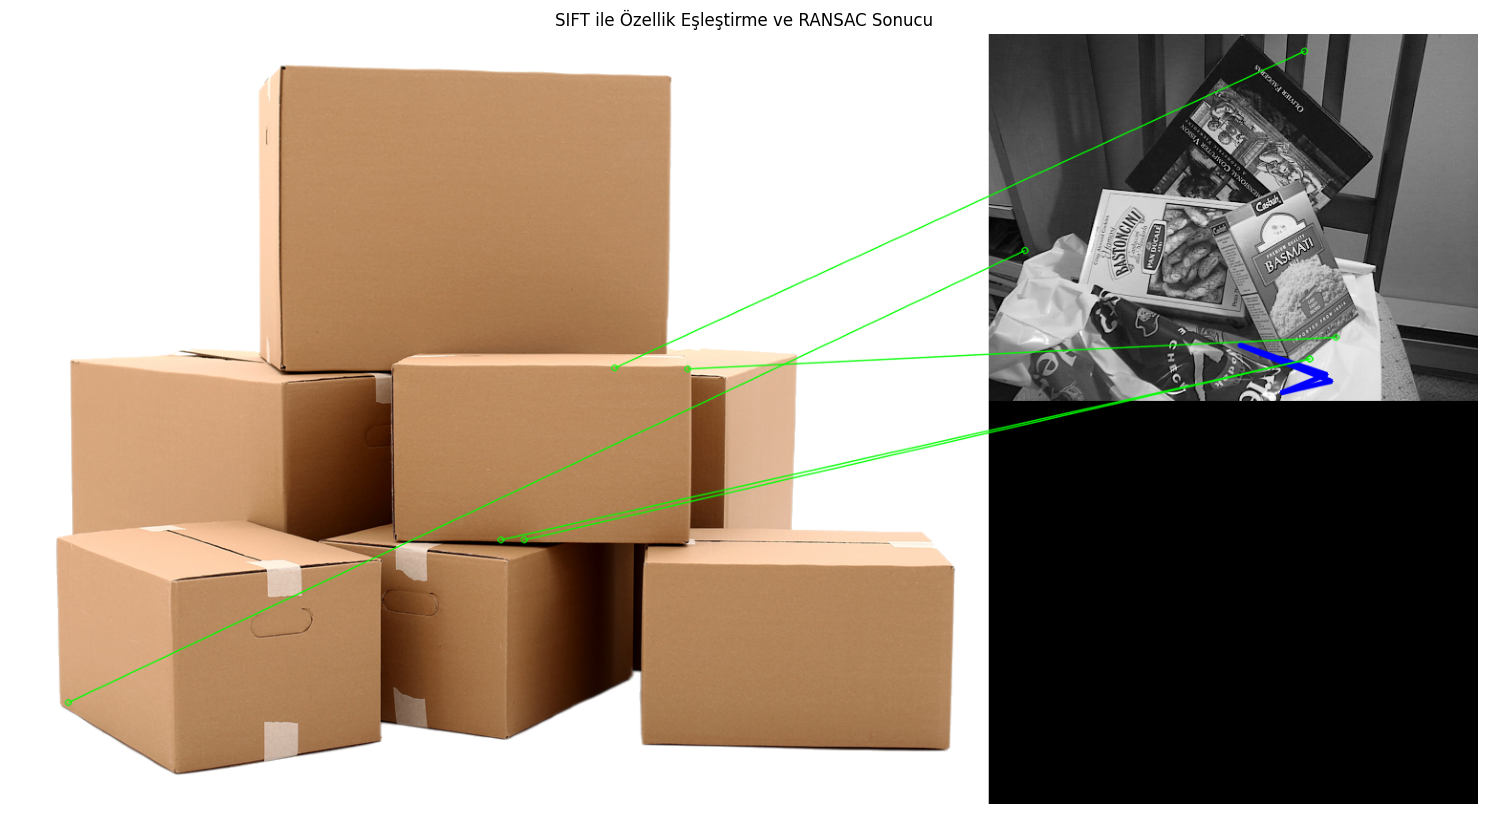


--- ORB ile Eşleştirme Başlatıldı ---
Bulunan 'iyi' eşleşme sayısı: 7
Yeterli eşleşme bulunamadı - 7/10


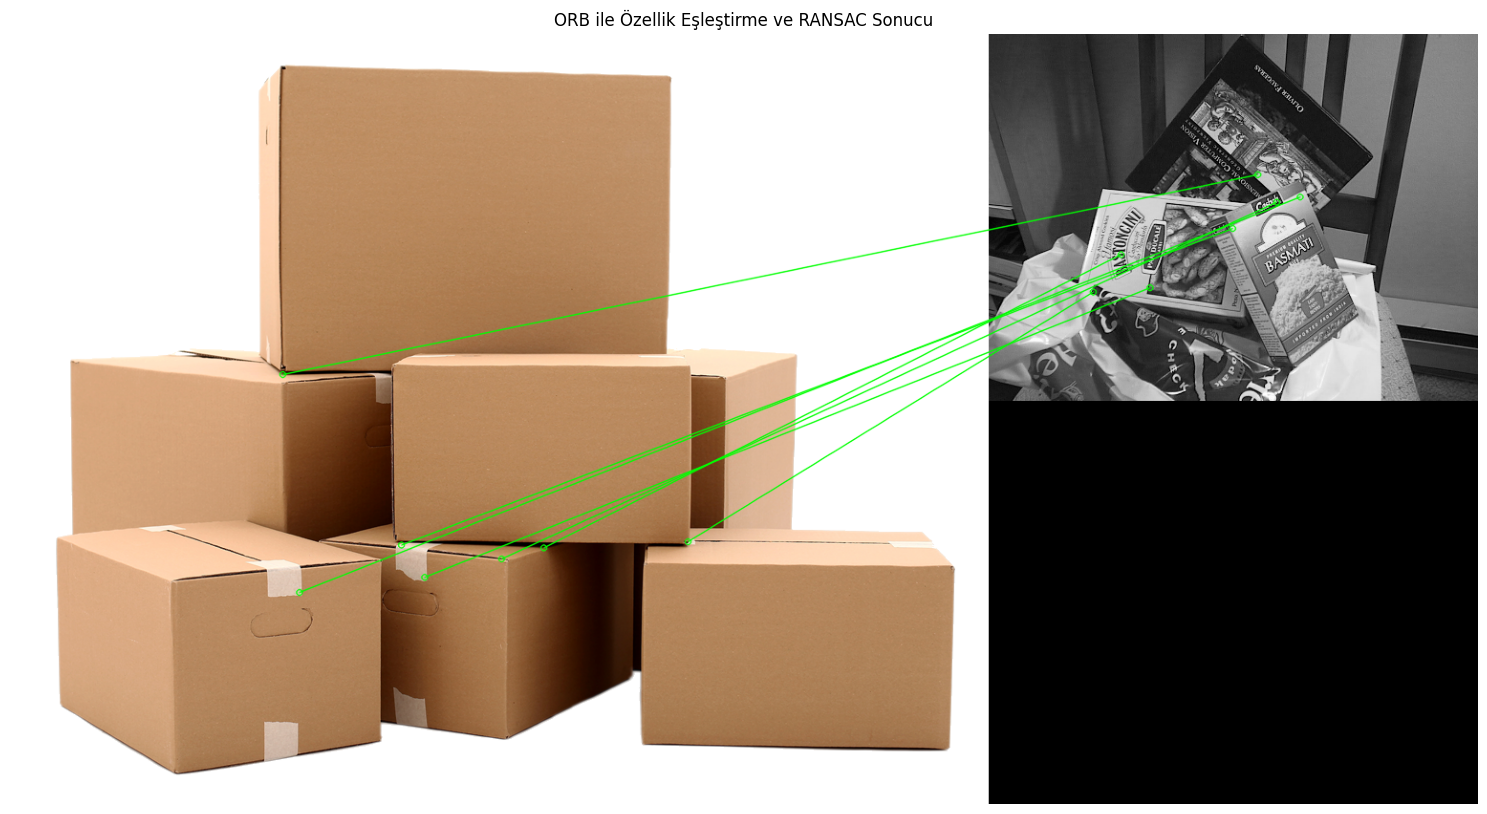

In [21]:
print("--- BÖLÜM 1: SIFT/ORB ile Özellik Eşleştirme ve RANSAC ---")

# Gerekli görüntüleri yükle
# 'box.png' aranacak nesne, 'box_in_scene.png' nesnenin bulunduğu sahne.
# Bu dosyaların notebook ile aynı dizinde olduğundan emin olun.
try:
    img_object = cv2.imread('box.png')
    img_scene = cv2.imread('box_in_scene.png')
    if img_object is None or img_scene is None:
        raise FileNotFoundError
    
    # SIFT ve ORB ile eşleştirme fonksiyonlarını çağır
    match_and_draw('SIFT', img_object, img_scene)
    match_and_draw('ORB', img_object, img_scene)

except FileNotFoundError:
    print("\nHata: Bölüm 1 için gerekli görüntü dosyaları (box.png, box_in_scene.png) bulunamadı.")
    print("Lütfen bu dosyaları internetten bularak notebook ile aynı dizine koyun.")



--- BÖLÜM 2: Bag of Visual Words ile Görüntü Arama ---
Görsel sözlük oluşturuluyor...
Toplam 1738 özellik üzerinden 50 kelimelik sözlük eğitiliyor...
Sözlük başarıyla oluşturuldu.

Sorgu Görüntüsü: araba1.jpg

En Benzer Görüntüler (Korelasyon Skoru):
1. manzara2.jpg (Skor: 0.1449)
2. manzara1.jpg (Skor: -0.1367)
3. araba2.jpg (Skor: -0.2007)


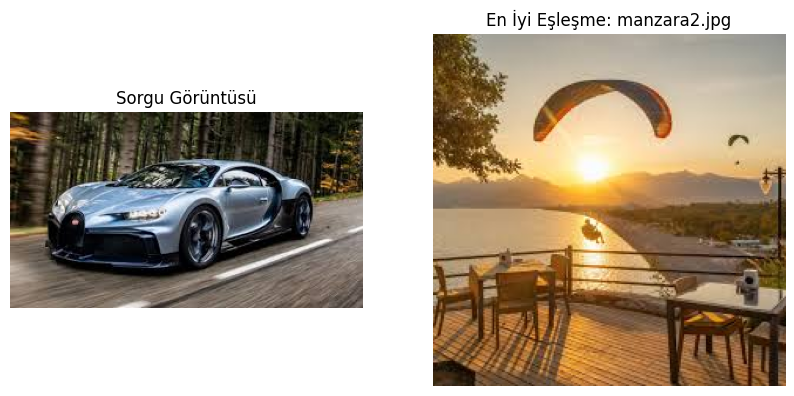

In [22]:
print("\n\n--- BÖLÜM 2: Bag of Visual Words ile Görüntü Arama ---")
    
# Basit bir resim veritabanı oluşturalım.
db_dir = 'db'
if not os.path.exists(db_dir):
    print(f"Uyarı: '{db_dir}' klasörü bulunamadı. BoVW bölümü atlanıyor.")
    print(f"Lütfen '{db_dir}' klasörü oluşturup içine 'manzara1.jpg', 'bina1.jpg' gibi resimler koyun.")
else:
    all_image_paths = [os.path.join(db_dir, f) for f in os.listdir(db_dir) if f.endswith(('.jpg', '.png'))]
    
    if len(all_image_paths) < 2:
        print(f"Uyarı: '{db_dir}' klasöründe BoVW için yeterli resim bulunamadı.")
    else:
        # BoVW modelini başlat ve sözlüğü oluştur
        bovw = BoVW(no_clusters=50)
        vocab_created = bovw.create_vocabulary(all_image_paths)
        
        if vocab_created:
            # Sorgu görüntüsü olarak veritabanından bir resim seçelim
            query_path = all_image_paths[0]
            print(f"\nSorgu Görüntüsü: {os.path.basename(query_path)}")
            
            query_img_gray = cv2.imread(query_path, cv2.IMREAD_GRAYSCALE)
            query_hist = bovw.get_histogram(query_img_gray)

            scores = []
            for path in all_image_paths:
                db_img_gray = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                db_hist = bovw.get_histogram(db_img_gray)
                
                # Histogramları karşılaştır
                score = cv2.compareHist(query_hist, db_hist, cv2.HISTCMP_CORREL)
                
                if path != query_path:
                    scores.append((score, path))
            
            scores.sort(reverse=True)
            
            print("\nEn Benzer Görüntüler (Korelasyon Skoru):")
            for i in range(min(3, len(scores))):
                print(f"{i+1}. {os.path.basename(scores[i][1])} (Skor: {scores[i][0]:.4f})")
            
            # En iyi eşleşmeyi göster
            best_match_path = scores[0][1]
            query_img_bgr = cv2.imread(query_path)
            best_match_img_bgr = cv2.imread(best_match_path)
            
            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            plt.imshow(cv2.cvtColor(query_img_bgr, cv2.COLOR_BGR2RGB))
            plt.title("Sorgu Görüntüsü")
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.imshow(cv2.cvtColor(best_match_img_bgr, cv2.COLOR_BGR2RGB))
            plt.title(f"En İyi Eşleşme: {os.path.basename(best_match_path)}")
            plt.axis('off')
            plt.show()

Görsel sözlük oluşturuluyor...
Toplam 1738 özellik üzerinden 50 kelimelik sözlük eğitiliyor...
Sözlük başarıyla oluşturuldu.

Sorgu Görüntüsü: araba1.jpg

En Benzer Görüntüler (Korelasyon Skoru):
1. manzara2.jpg (Skor: 0.1449)
2. manzara1.jpg (Skor: -0.1367)
3. araba2.jpg (Skor: -0.2007)


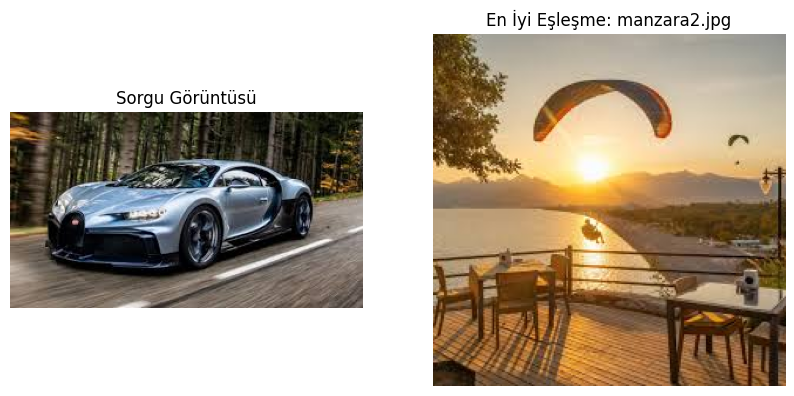

In [23]:
db_dir = 'db'
if not os.path.exists(db_dir):
    print(f"Uyarı: '{db_dir}' klasörü bulunamadı. Lütfen oluşturup içine resimler ekleyin.")
else:
    # Veritabanı resim yollarını topla
    all_image_paths = [os.path.join(db_dir, f) for f in os.listdir(db_dir) if f.endswith(('.jpg', '.png'))]
    
    if len(all_image_paths) < 2:
        print(f"Uyarı: '{db_dir}' klasöründe BoVW için yeterli resim bulunamadı.")
    else:
        # BoVW modelini başlat ve sözlüğü oluştur
        bovw = BoVW(no_clusters=50)
        vocab_created = bovw.create_vocabulary(all_image_paths)
        
        if vocab_created:
            # Sorgu görüntüsü olarak veritabanından bir resim seçelim
            query_path = all_image_paths[0]
            print(f"\nSorgu Görüntüsü: {os.path.basename(query_path)}")
            
            query_img_gray = cv2.imread(query_path, cv2.IMREAD_GRAYSCALE)
            query_hist = bovw.get_histogram(query_img_gray)

            scores = []
            for path in all_image_paths:
                db_img_gray = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                db_hist = bovw.get_histogram(db_img_gray)
                
                # Histogramları karşılaştır. 1.0'e yakın skor daha iyi eşleşme demektir.
                # (cv2.HISTCMP_CORREL metodu korelasyonu ölçer)
                score = cv2.compareHist(query_hist, db_hist, cv2.HISTCMP_CORREL)
                
                # Kendisiyle karşılaştırmayı atla
                if path != query_path:
                    scores.append((score, path))
            
            # Skorları sırala (en yüksek korelasyondan en düşüğe)
            scores.sort(reverse=True)
            
            print("\nEn Benzer Görüntüler (Korelasyon Skoru):")
            for i in range(min(3, len(scores))):
                print(f"{i+1}. {os.path.basename(scores[i][1])} (Skor: {scores[i][0]:.4f})")
            
            # En iyi eşleşmeyi göster
            best_match_path = scores[0][1]
            query_img_bgr = cv2.imread(query_path)
            best_match_img_bgr = cv2.imread(best_match_path)
            
            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            plt.imshow(cv2.cvtColor(query_img_bgr, cv2.COLOR_BGR2RGB))
            plt.title("Sorgu Görüntüsü")
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.imshow(cv2.cvtColor(best_match_img_bgr, cv2.COLOR_BGR2RGB))
            plt.title(f"En İyi Eşleşme: {os.path.basename(best_match_path)}")
            plt.axis('off')
            plt.show()